In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import math
import pickle

In [2]:
y_train = np.load("/home/notchla/Documents/mias_y_train.npy", allow_pickle=True)
y_val = np.load("/home/notchla/Documents/mias_y_val.npy", allow_pickle=True)
x_train = np.load("/home/notchla/Documents/mias_x_train.npy", allow_pickle=True)
x_val = np.load("/home/notchla/Documents/mias_x_val.npy", allow_pickle=True)

print(np.max(y_train), np.max(y_val), np.max(x_train), np.max(x_val))

1.0 0.9568628 1.0 1.0


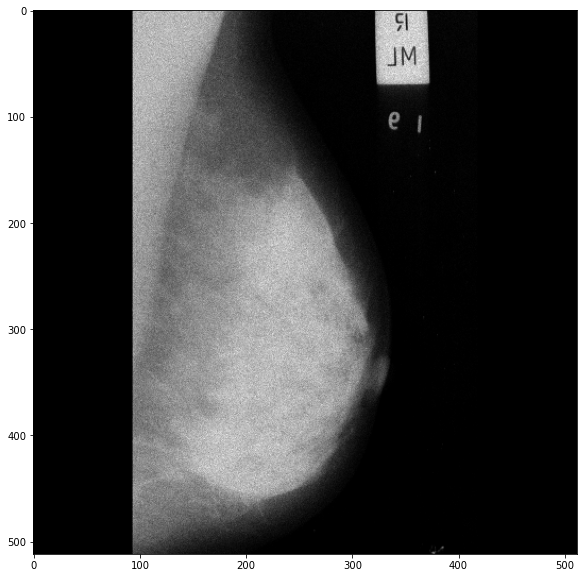

In [3]:
plt.figure(figsize=(10,10))
plt.imshow(x_val[0])
plt.gray()

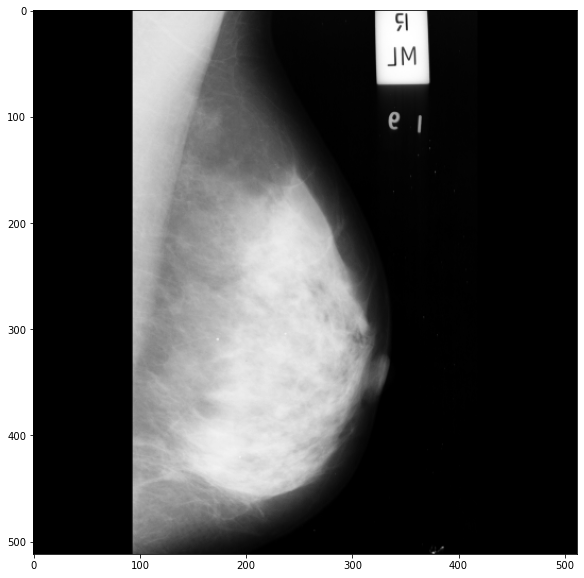

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(y_val[0])
plt.gray()

In [5]:
y_val_tensor = tf.convert_to_tensor(y_val, dtype="float32")
grad_components = tf.image.sobel_edges(y_val_tensor)
grad_mag_components = grad_components**2
grad_mag_square = tf.math.reduce_sum(grad_mag_components, axis=-1)
grad_mag_img = tf.sqrt(grad_mag_square)
y_val_sobel = grad_mag_img.numpy()

y_val_sobel /= math.sqrt(32) #max possible value in the l2 sum of the 2 magnitudes

In [6]:
y_train_tensor = tf.convert_to_tensor(y_train, dtype="float32")
grad_components = tf.image.sobel_edges(y_train_tensor)
grad_mag_components = grad_components**2
grad_mag_square = tf.math.reduce_sum(grad_mag_components, axis=-1)
grad_mag_img = tf.sqrt(grad_mag_square)
y_train_sobel = grad_mag_img.numpy()

y_train_sobel /= math.sqrt(32)

In [7]:
print(np.max(y_train_sobel))

0.706608


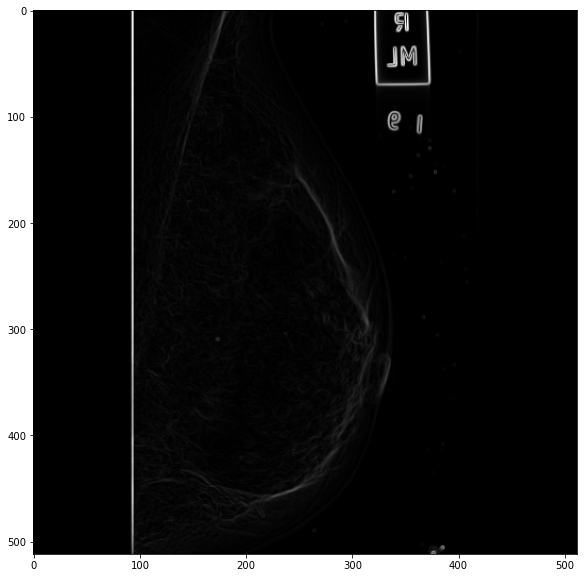

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(y_val_sobel[0])
plt.gray()

In [9]:
#create patches
PATCHING_SIZE = 64
ksize_rows = PATCHING_SIZE
ksize_cols = PATCHING_SIZE
strides_rows = PATCHING_SIZE
strides_cols = PATCHING_SIZE

ksizes = [1, ksize_rows, ksize_cols, 1]
strides = [1, strides_rows, strides_cols, 1]
rates = [1, 1, 1, 1]
padding = "VALID"

y_train_patches = tf.image.extract_patches(y_train, ksizes, strides, rates, padding)
x_train_patches = tf.image.extract_patches(x_train, ksizes, strides, rates, padding)
x_val_patches = tf.image.extract_patches(x_val, ksizes, strides, rates, padding)
y_val_patches = tf.image.extract_patches(y_val, ksizes, strides, rates, padding)
y_val_sobel_patches = tf.image.extract_patches(y_val_sobel, ksizes, strides, rates, padding)
y_train_sobel_patches = tf.image.extract_patches(y_train_sobel, ksizes, strides, rates, padding)


In [10]:
axis_0, axis_1, axis_2, channel = x_train.shape
print(axis_0, axis_1, axis_2, channel)

258 512 512 1


In [11]:
IMAGES_TRAIN = axis_0

In [12]:
nsamples_train = int(axis_0*(axis_1/PATCHING_SIZE)*(axis_2/PATCHING_SIZE))
x_train_patches = np.reshape(x_train_patches, [nsamples_train, PATCHING_SIZE, PATCHING_SIZE, channel])
y_train_patches = np.reshape(y_train_patches, [nsamples_train, PATCHING_SIZE, PATCHING_SIZE, channel])
y_train_sobel_patches = np.reshape(y_train_sobel_patches, [nsamples_train, PATCHING_SIZE, PATCHING_SIZE, channel])


In [13]:
axis_0, axis_1, axis_2, channel = x_val.shape
print(axis_0, axis_1, axis_2, channel)

64 512 512 1


In [14]:
IMAGES_VAL = axis_0

In [15]:
nsamples_train = int(axis_0*(axis_1/PATCHING_SIZE)*(axis_2/PATCHING_SIZE))
x_val_patches = np.reshape(x_val_patches, [nsamples_train, PATCHING_SIZE, PATCHING_SIZE, channel])
y_val_patches = np.reshape(y_val_patches, [nsamples_train, PATCHING_SIZE, PATCHING_SIZE, channel])
y_val_sobel_patches = np.reshape(y_val_sobel_patches, [nsamples_train, PATCHING_SIZE, PATCHING_SIZE, channel])



In [16]:
del y_train
del x_train
del x_val
del y_val
del y_train_sobel
del y_val_sobel

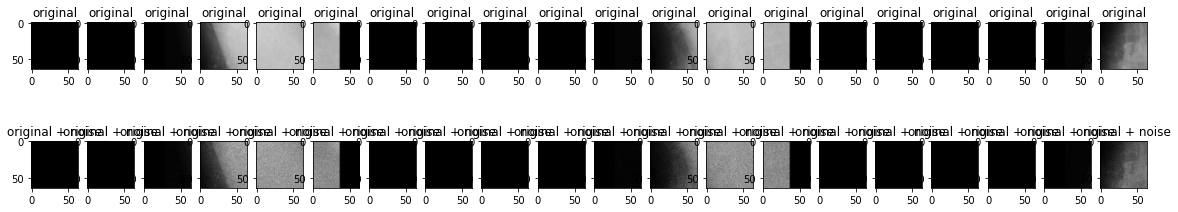

In [17]:
n = 20
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(y_train_patches[i], cmap="gray", vmin=0, vmax=1)
  plt.title("original")
  plt.gray()

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(x_train_patches[i], cmap="gray", vmin=0, vmax=1)
  plt.title("original + noise")
  plt.gray()

In [18]:
img_height = 64
img_width = 64

In [19]:
print (tf.__version__)

2.4.0


In [20]:
class ResidualUnit(tf.keras.layers.Layer):
  def __init__(self, strides=1, activation="relu", **kwargs):
    super(ResidualUnit, self).__init__(**kwargs)
    self.activation = tf.keras.activations.get(activation)
    self.main_layers = [layers.Conv2D(32, (3,3), kernel_initializer=initializers.random_normal(stddev=0.001), padding="same"),
                        self.activation,
                        layers.Conv2D(32, (3,3), kernel_initializer=initializers.random_normal(stddev=0.001), padding="same")]
  def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
    return inputs + Z
  def get_config(self):
    return {"resconv" : self.main_layers}

In [21]:
class MyModel(tf.keras.Model):
  def __init__(self, residuals = 0):
    super(MyModel, self).__init__()
    self.conv1 = layers.Conv2D(64, (9,9), strides=1, kernel_initializer=initializers.random_normal(stddev=0.001), padding="same", name="conv1")
    self.conv2 = layers.Conv2D(32, (5,5), strides=1, kernel_initializer=initializers.random_normal(stddev=0.001), padding="same", name="conv2")
    self.conv3 = layers.Conv2D(1, (5,5), strides=1, kernel_initializer=initializers.random_normal(stddev=0.001), padding="same", name="conv3")
    self.residuals = [ResidualUnit() for i in range(residuals)]
  def call(self, inputs):
    x, edge = inputs
    x = self.conv1(x)
    x = self.conv2(x)
    for res in self.residuals:
      x = res(x)
    x = self.conv3(x)
    return x, edge*x 
  def model(self): #used to print model summary
    x = tf.keras.layers.Input(shape=(64,64,1))
    y = tf.keras.layers.Input(shape=(64, 64, 1))
    return tf.keras.Model(inputs=[x, y], outputs=self.call([x,y]))
  def addResidual(self):
    self.residuals.append(ResidualUnit())
  def set_res_weights(self, weights):
    for weight, res in zip(weights, self.residuals):
      res.set_weights(weight)
  def inheritWeights(self,residuals):
    self.conv1.trainable = False
    self.conv2.trainable = False
    self.conv3.trainable = False
    for i in range(residuals):
      self.residuals[i].trainable = False
  def get_res_weights(self):
    tmp = []
    for res in self.residuals:
      tmp.append(res.get_weights())
    return tmp

In [22]:
mymodel = MyModel()
mymodel.model().summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   5248        input_1[0][0]                    
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 64, 64, 32)   51232       conv1[0][0]                      
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, 64, 64, 1)    801         conv2[0][0]                      
______________________________________________________________________________________________

In [23]:
# x_expanded = np.expand_dims(x_train, axis=1)
# zeros = np.expand_dims(zeros, axis=1)

# test = np.concatenate((x_expanded, zeros), axis=1)

In [24]:
mymodel.compile(optimizer="adam", loss=[tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanSquaredError()], loss_weights=[0.5, 0.1])

In [25]:
sobel_train = y_train_sobel_patches * y_train_patches
sobel_val = y_val_sobel_patches * y_val_patches

In [26]:
history = mymodel.fit([x_train_patches, y_train_sobel_patches], [y_train_patches, sobel_train], epochs=10, shuffle=True, validation_data=([x_val_patches, y_val_sobel_patches], [y_val_patches, sobel_val]))

Epoch 1/10
516/516 [==============================] - 8s 14ms/step - loss: 0.0057 - output_1_loss: 0.0113 - output_2_loss: 7.7378e-05 - val_loss: 2.2119e-04 - val_output_1_loss: 4.3810e-04 - val_output_2_loss: 2.1374e-05
Epoch 2/10
516/516 [==============================] - 7s 14ms/step - loss: 1.5763e-04 - output_1_loss: 3.1144e-04 - output_2_loss: 1.9082e-05 - val_loss: 1.4545e-04 - val_output_1_loss: 2.8867e-04 - val_output_2_loss: 1.1181e-05
Epoch 3/10
516/516 [==============================] - 7s 14ms/step - loss: 1.3302e-04 - output_1_loss: 2.6407e-04 - output_2_loss: 9.8559e-06 - val_loss: 1.3011e-04 - val_output_1_loss: 2.5873e-04 - val_output_2_loss: 7.4215e-06
Epoch 4/10
516/516 [==============================] - 7s 14ms/step - loss: 1.7562e-04 - output_1_loss: 3.4974e-04 - output_2_loss: 7.4892e-06 - val_loss: 1.0521e-04 - val_output_1_loss: 2.0933e-04 - val_output_2_loss: 5.4555e-06
Epoch 5/10
516/516 [==============================] - 7s 14ms/step - loss: 1.4661e-04 - outp

In [27]:
with open("/home/notchla/Documents/history0", "wb") as file:
    pickle.dump(history.history, file)

In [28]:
res = []

In [29]:
def cascadeTraining(model, residuals, epochs):
    old_weights = model.get_weights()
    old_model = model
    for i in range(residuals):
        model.addResidual()
        model.inheritWeights(i)
        model.compile(optimizer="adam", loss=[tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanSquaredError()], loss_weights=[1, 0.1])
        info = model.fit([x_train_patches, y_train_sobel_patches], [y_train_patches, sobel_train], epochs=epochs, shuffle=True, validation_data=([x_val_patches, y_val_sobel_patches], [y_val_patches, sobel_val]))
        model.model().summary()
        res.append(model.get_res_weights())
        for layer in model.layers: print(layer.get_config())
        with open("/home/notchla/Documents/history" + str(i+1), "wb") as file:
            pickle.dump(info.history, file)

In [30]:
cascadeTraining(mymodel, 5, 10)

e-06 - val_loss: 1.4660e-04 - val_output_1_loss: 1.4649e-04 - val_output_2_loss: 1.1529e-06
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   5248        input_7[0][0]                    
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 64, 64, 32)   51232       conv1[3][0]                      
__________________________________________________________________________________________________
residual_unit (ResidualUnit)    (None, 64, 64, 32)   18496       conv2[3][0]                      


In [31]:
decoded = mymodel((x_val_patches[:256], y_val_sobel_patches[:256]))

In [32]:
decoded = [x / np.max(x) for x in decoded]

In [33]:
print(np.max(decoded[0]))

1.0


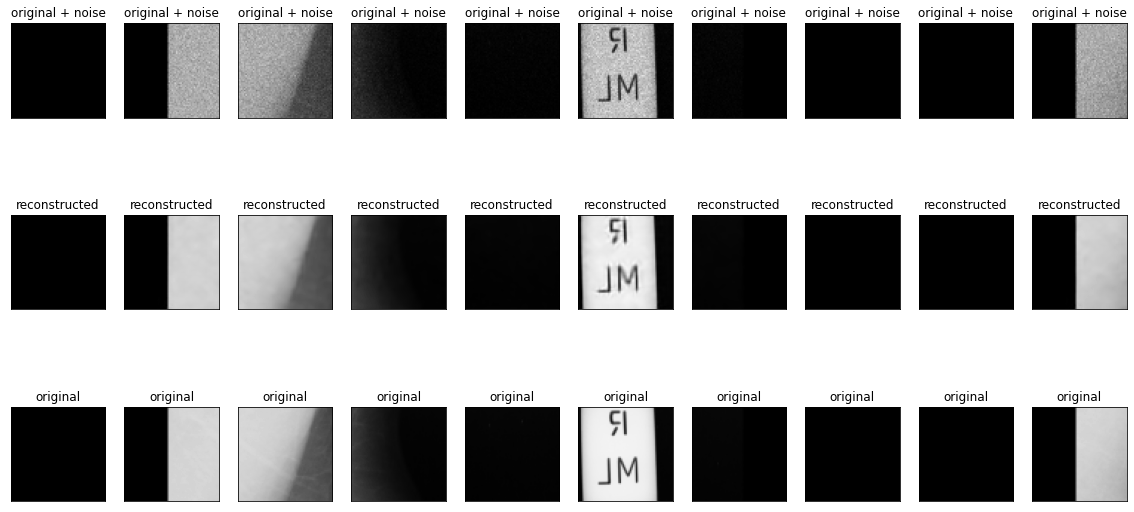

In [34]:
n = 10
plt.figure(figsize=(20, 10))
for i in range(n):

    # display original + noise
    ax = plt.subplot(3, n, i + 1)
    plt.title("original + noise")
    plt.imshow(x_val_patches[i], cmap="gray", vmin=0, vmax=1)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(decoded[0][i], cmap="gray", vmin=0, vmax=1)
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    #display original
    bx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("original")
    plt.imshow(y_val_patches[i], cmap="gray", vmin=0, vmax=1)
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

plt.show()

In [35]:
'''def reconstruct(patches, width, height, noriginal, dims):
    original = np.empty((noriginal, width, height, dims))
    (npatches, pwidth, pheight, pchannel) = patches.shape
    nwidth = int(width / pwidth)
    nheight = int(height / pheight)
    print(nwidth, nheight)
    for i in range(noriginal):
        for j in range(nheight):
            insert = patches[j*nwidth:(j+1)*nwidth]
            print(insert.shape)
            insert = np.reshape(insert, (width, pheight, dims))
            print(insert.shape)
            original[i, :, j*pheight:(j+1)*pheight] = insert

    return original'''


'def reconstruct(patches, width, height, noriginal, dims):\n    original = np.empty((noriginal, width, height, dims))\n    (npatches, pwidth, pheight, pchannel) = patches.shape\n    nwidth = int(width / pwidth)\n    nheight = int(height / pheight)\n    print(nwidth, nheight)\n    for i in range(noriginal):\n        for j in range(nheight):\n            insert = patches[j*nwidth:(j+1)*nwidth]\n            print(insert.shape)\n            insert = np.reshape(insert, (width, pheight, dims))\n            print(insert.shape)\n            original[i, :, j*pheight:(j+1)*pheight] = insert\n\n    return original'

In [36]:
#should be vectorized for rows
def reconstruct(patches, width, height, noriginal, dims):
    original = np.empty((noriginal, width, height, dims))
    (npatches, pwidth, pheight, pchannel) = patches.shape
    nwidth = int(width / pwidth)
    nheight = int(height / pheight)
    for i in range(noriginal):
        for j in range(nheight):
            for k in range(nwidth):
                insert = patches[((j * nheight) + k)+(i*nwidth*nheight)]
                original[i, j*pheight:(j+1)*pheight,k*pwidth:(k+1)*pwidth] = insert

    return original


In [37]:
y_val = reconstruct(y_val_patches, 512, 512, 64, 1)
x_val = reconstruct(x_val_patches, 512, 512, 64, 1)
x_train = reconstruct(x_train_patches, 512, 512, 258, 1)
y_train = reconstruct(y_train_patches, 512, 512, 258, 1)

recon = reconstruct(decoded[0], 512,512, 4,1)


In [38]:
recon.shape

(4, 512, 512, 1)

In [39]:
print(np.max(recon))

1.0


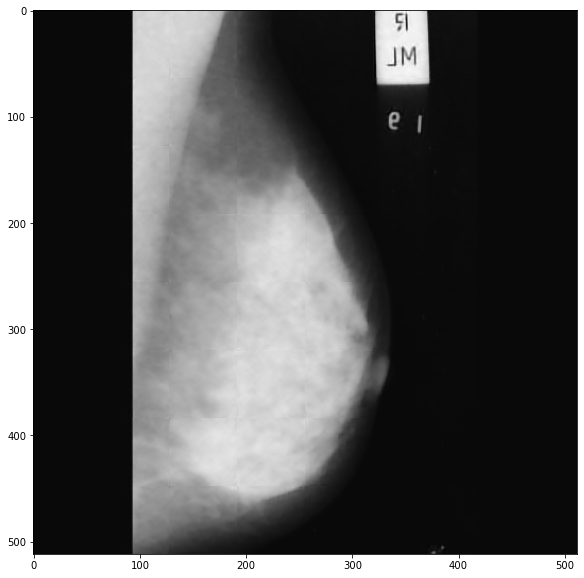

In [40]:
plt.figure(figsize=(10,10))
plt.imshow(recon[0])
plt.gray()

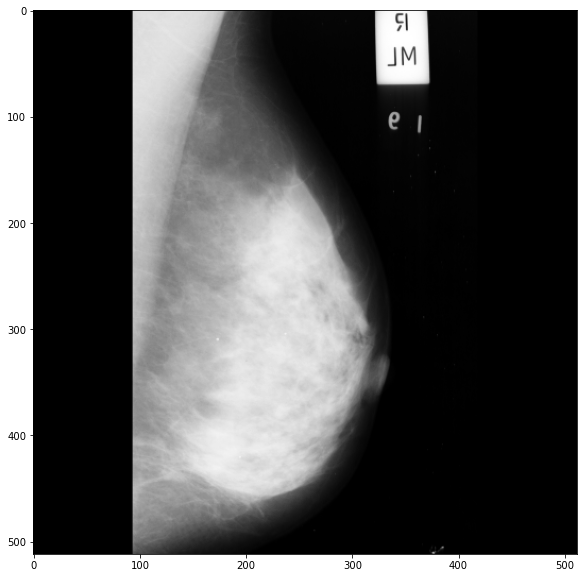

In [41]:
plt.figure(figsize=(10,10))
plt.imshow(y_val[0])
plt.gray()

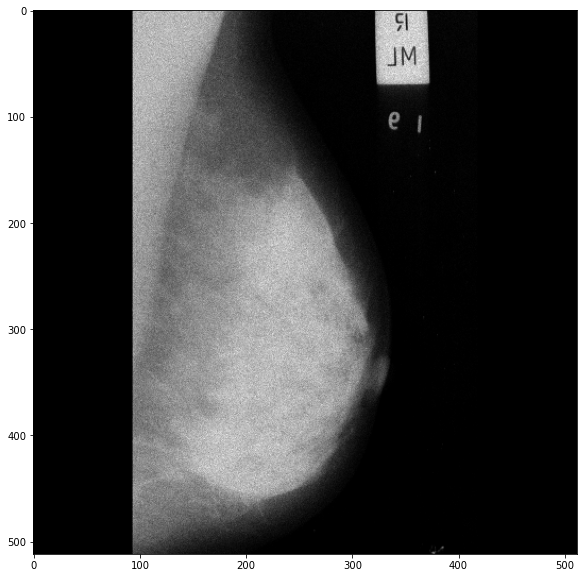

In [42]:
plt.figure(figsize=(10,10))
plt.imshow(x_val[0])
plt.gray()

In [43]:
ssim = tf.image.ssim(y_val[:4], recon, max_val=1.0)
psnr = tf.image.psnr(y_val[:4], recon, max_val = 1.0)

In [44]:
print(ssim, psnr)

tf.Tensor([0.9729478  0.9710037  0.97949463 0.977276  ], shape=(4,), dtype=float32) tf.Tensor([38.3772   38.577118 41.546444 40.461124], shape=(4,), dtype=float32)


In [45]:
loss_list = []
def merge_history(nhistory):
    for i in range(nhistory + 1):
        with open("/home/notchla/Documents/history" + str(i), "rb") as file:
            while True:
                try:
                    loss_list.append(pickle.load(file))
                except EOFError:
                    break

In [46]:
merge_history(5)

In [47]:
loss_model = []
valloss_model = []
for loss in loss_list:
    loss_model += loss["loss"]
    valloss_model += loss["val_loss"]

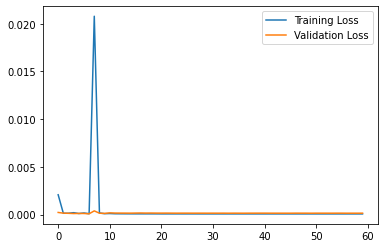

In [48]:
plt.plot(loss_model, label="Training Loss")
plt.plot(valloss_model, label="Validation Loss")
plt.legend()

In [49]:
for i in range(len(res) - 1):
    for j, k in zip(res[i], res[i + 1]):
        for la, lb in zip(j, k):
            print(i, la.shape, lb.shape)
            np.testing.assert_allclose(la, lb)

0 (3, 3, 32, 32) (3, 3, 32, 32)
0 (32,) (32,)
0 (3, 3, 32, 32) (3, 3, 32, 32)
0 (32,) (32,)
1 (3, 3, 32, 32) (3, 3, 32, 32)
1 (32,) (32,)
1 (3, 3, 32, 32) (3, 3, 32, 32)
1 (32,) (32,)
1 (3, 3, 32, 32) (3, 3, 32, 32)
1 (32,) (32,)
1 (3, 3, 32, 32) (3, 3, 32, 32)
1 (32,) (32,)
2 (3, 3, 32, 32) (3, 3, 32, 32)
2 (32,) (32,)
2 (3, 3, 32, 32) (3, 3, 32, 32)
2 (32,) (32,)
2 (3, 3, 32, 32) (3, 3, 32, 32)
2 (32,) (32,)
2 (3, 3, 32, 32) (3, 3, 32, 32)
2 (32,) (32,)
2 (3, 3, 32, 32) (3, 3, 32, 32)
2 (32,) (32,)
2 (3, 3, 32, 32) (3, 3, 32, 32)
2 (32,) (32,)
3 (3, 3, 32, 32) (3, 3, 32, 32)
3 (32,) (32,)
3 (3, 3, 32, 32) (3, 3, 32, 32)
3 (32,) (32,)
3 (3, 3, 32, 32) (3, 3, 32, 32)
3 (32,) (32,)
3 (3, 3, 32, 32) (3, 3, 32, 32)
3 (32,) (32,)
3 (3, 3, 32, 32) (3, 3, 32, 32)
3 (32,) (32,)
3 (3, 3, 32, 32) (3, 3, 32, 32)
3 (32,) (32,)
3 (3, 3, 32, 32) (3, 3, 32, 32)
3 (32,) (32,)
3 (3, 3, 32, 32) (3, 3, 32, 32)
3 (32,) (32,)
